In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow.keras as K

import pickle
from zipfile import ZipFile, ZIP_DEFLATED

In [32]:
fashion_mnist = K.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

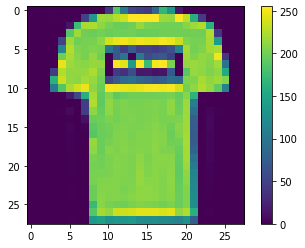

In [33]:
plt.figure()
plt.imshow(train_images[train_labels == 0][0])
plt.colorbar()
plt.grid(False)
plt.show()

In [35]:
reshape_2d = lambda X: X.reshape(X.shape[0], np.product(X.shape[1:]))

X_train = reshape_2d(train_images)
X_test = reshape_2d(test_images)

y_train = train_labels
y_test = test_labels

svc = make_pipeline(
    MinMaxScaler(),
    SVC()
)

In [6]:
%time svc.fit(X_train, y_train)

CPU times: user 6min 28s, sys: 2.62 s, total: 6min 30s
Wall time: 6min 32s


Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svc', SVC())])

In [36]:
# with ZipFile('svc.zip', 'x', compression=ZIP_DEFLATED) as f:
#     f.writestr('svc.pickle', pickle.dumps(svc))
with ZipFile('svc.zip', 'r') as f:
    svc = pickle.loads(f.read('svc.pickle'))

In [30]:
%time accuracy_score(svc.predict(X_test), y_test)

CPU times: user 3min 47s, sys: 179 ms, total: 3min 47s
Wall time: 3min 49s


0.8829

In [46]:
mlp = make_pipeline(
    MinMaxScaler(),
    MLPClassifier(early_stopping=True, verbose=True)
)

In [47]:
%time mlp.fit(X_train, y_train)

Iteration 1, loss = 0.61131821
Validation score: 0.840333
Iteration 2, loss = 0.43244805
Validation score: 0.853000
Iteration 3, loss = 0.38934420
Validation score: 0.862000
Iteration 4, loss = 0.36608853
Validation score: 0.877167
Iteration 5, loss = 0.34732336
Validation score: 0.874500
Iteration 6, loss = 0.33114487
Validation score: 0.866833
Iteration 7, loss = 0.31832689
Validation score: 0.874167
Iteration 8, loss = 0.30508123
Validation score: 0.881000
Iteration 9, loss = 0.29798159
Validation score: 0.877000
Iteration 10, loss = 0.28690735
Validation score: 0.880333
Iteration 11, loss = 0.28101085
Validation score: 0.874667
Iteration 12, loss = 0.27427755
Validation score: 0.885333
Iteration 13, loss = 0.26739319
Validation score: 0.879167
Iteration 14, loss = 0.26245442
Validation score: 0.887167
Iteration 15, loss = 0.25408786
Validation score: 0.888500
Iteration 16, loss = 0.24653524
Validation score: 0.889500
Iteration 17, loss = 0.24632591
Validation score: 0.873833
Iterat

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('mlpclassifier',
                 MLPClassifier(early_stopping=True, verbose=True))])

In [49]:
# with ZipFile('mlp.zip', 'x', compression=ZIP_DEFLATED) as f:
#     f.writestr('mlp.pickle', pickle.dumps(mlp))
with ZipFile('mlp.zip', 'r') as f:
    mlp = pickle.loads(f.read('mlp.pickle'))

In [50]:
%time accuracy_score(mlp.predict(X_test), y_test)

CPU times: user 365 ms, sys: 76.3 ms, total: 441 ms
Wall time: 194 ms


0.8874

In [3]:
K.applications.ResNet50V2()

102875136/102869336 [==============================] - 12s 0us/step
